# 超分辨率

本文档演示了在 Enhanced Super Resolution Generative Adversarial Network（由 Xintao Wang 等人撰写）中如何使用 TensorFlow Hub 模块进行**图像增强**。（最好使用双三次降采样的图像。）[查看论文](https://arxiv.org/pdf/1809.00219.pdf)

模型在 DIV2K 数据集（双三次降采样的图像）中大小为 128 x 128 的图像块上进行了训练。

## 准备环境

In [1]:
! pip install -U tensorflow_hub
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
# tensorflow 版本为2.3.1
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/


In [2]:
! wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2021-03-26 02:38:06--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: 'original.png'

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.1s    

2021-03-26 02:38:08 (262 KB/s) - 'original.png' saved [34146/34146]



In [3]:
# Declaring Constants（定义常量）
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "./model/"
# SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

## 定义辅助函数

In [4]:
def preprocess_image(image_path):
    """ 
        从路径加载图像并进行预处理，使其为模型做好准备
        参数：
            image_path：图像文件的路径
    """
    print(image_path)
    hr_image = tf.image.decode_image(tf.io.read_file(image_path), channels=3)
    # 如果图片是 PNG，请移除 alpha 通道。该模型仅支持具有 3 个颜色通道的图像。
    if hr_image.shape[-1] == 4:
        hr_image = hr_image[...,:-1]
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def save_image(image, filename):
    """
        保存未缩放的张量图像。
        参数：
            image：三维图像张量。（高度、宽度、通道）
            filename：要保存到的文件的名称。
    """
    if not isinstance(image, Image.Image):
        image = tf.clip_by_value(image, 0, 255)
        image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    image.save("%s.jpg" % filename)
    print("保存为 %s.jpg" % filename)

In [5]:
%matplotlib inline
def plot_image(image, title=""):
    """
        使用图像张量打印图像。
        参数：
            image：三维图像张量。（高度、宽度、通道）
            title：要在绘图中显示的标题。
    """
    image = np.asarray(image)
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)

## 对从路径加载的图像执行超解析

In [6]:
hr_image = preprocess_image(IMAGE_PATH)

original.png


保存为 Original Image.jpg


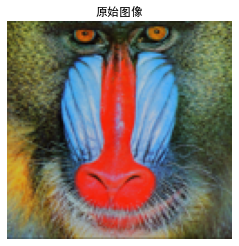

In [7]:
# Plotting Original Resolution image（绘制原始分辨率图像）
plot_image(tf.squeeze(hr_image), title="原始图像")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [8]:
model = hub.load(SAVED_MODEL_PATH)

In [9]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("花费时间： %f" % (time.time() - start))

花费时间： 9.920265


保存为 Super Resolution.jpg


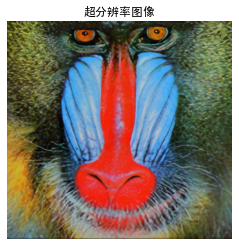

In [10]:
# Plotting Super Resolution Image（绘制超分辨率图像）
plot_image(tf.squeeze(fake_image), title="超分辨率图像")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [11]:
# !wget "https://lh4.googleusercontent.com/-Anmw5df4gj0/AAAAAAAAAAI/AAAAAAAAAAc/6HxU8XFLnQE/photo.jpg64" -O test.jpg
IMAGE_PATH = "test.jpg"

In [12]:
# Defining helper functions（定义辅助函数）
def downscale_image(image):
  """
    使用双三次插值（bicubic downsampling）的图像。
    参数：
        image：预处理图像的三维或四维张量
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else: #维度不匹配，只能在单个图像上工作。
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [13]:
hr_image = preprocess_image(IMAGE_PATH)

test.jpg


In [14]:
lr_image = downscale_image(tf.squeeze(hr_image))

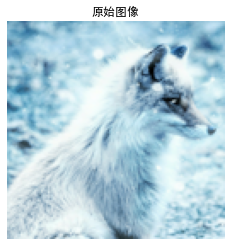

In [15]:
# Plotting Low Resolution Image（绘制原始分辨率图像）
plot_image(tf.squeeze(lr_image), title="原始图像")

In [16]:
model = hub.load(SAVED_MODEL_PATH)

In [17]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("花费时间: %f" % (time.time() - start))

花费时间: 12.684116


峰值信噪比: 28.029171


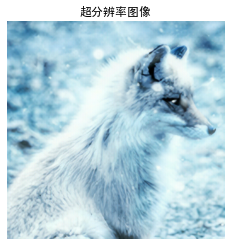

In [18]:
plot_image(tf.squeeze(fake_image), title="超分辨率图像")
# Calculating PSNR wrt Original Image（计算原始图像的峰值信噪比）
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("峰值信噪比: %f" % psnr)

## 并排比较输出大小

PSNR: 28.029171


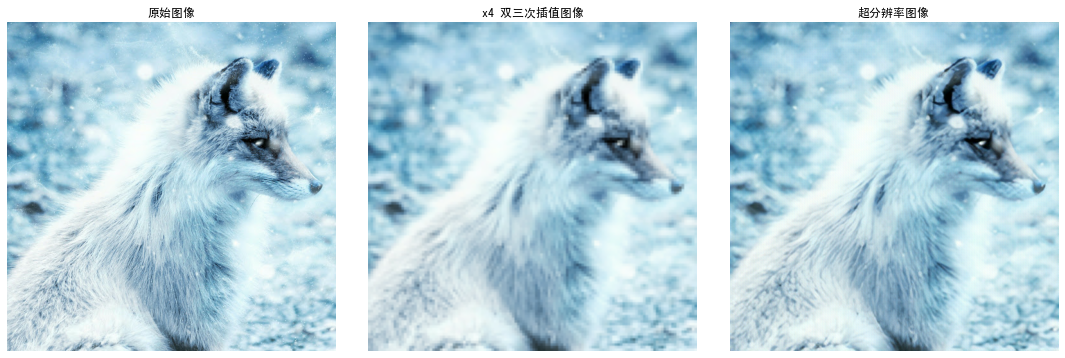

In [19]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="原始图像")
plt.subplot(132)
fig.tight_layout()
plot_image(tf.squeeze(lr_image), "x4 双三次插值图像")
plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "超分辨率图像")
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")
print("PSNR: %f" % psnr)